In [1]:
#импортирование библиотек

#если ещё не установлен:
#!pip install PyMySQL

import sqlalchemy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pymysql
import scipy.stats as st
import mplcyberpunk

In [2]:
#подключение к БД

host = 'localhost'
user = 'root'
password = '123'
port = '3306'
base = 'skillbox_final'

conn = f'mysql+pymysql://{user}:{password}@{host}:{port}/{base}'
engine = sqlalchemy.create_engine(conn)
connect = engine.connect()
metadata = sqlalchemy.MetaData()

In [3]:
#загрузка в блокнот таблиц из БД

platforms = pd.read_sql('platforms', connect)
platforms.drop_duplicates(inplace=True)

money = pd.read_sql('money', connect)
money.drop_duplicates(inplace=True)

cash = pd.read_sql('cash', connect)
cash.drop_duplicates(inplace=True)

abgroup = pd.read_sql('abgroup', connect)
abgroup.drop_duplicates(inplace=True)

In [4]:
money_value = money.groupby(['user_id']).agg({'money': 'sum'})
cash_value = cash.groupby(['user_id']).agg({'cash': 'sum'})
money_value_on = money_value[money_value['money'] == 0]
cash_value_on = cash_value[cash_value['cash'] != 0]

<Axes: >

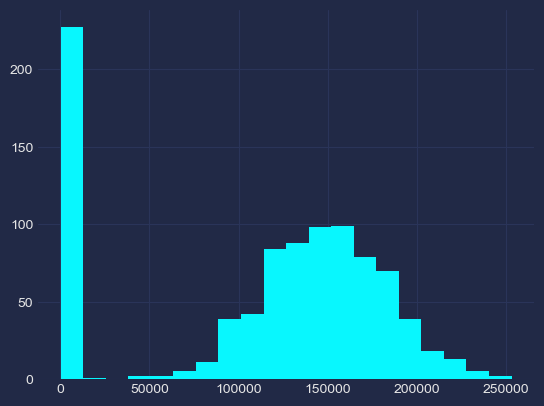

In [50]:
#распределение кол-ва потраченной валюты у таких игроков
plt.style.use("cyberpunk")

potential_cheaters = pd.merge(money_value_on, cash_value_on, how='left', left_on='user_id', right_on='user_id').reset_index()

potential_cheaters['cash'].hist(bins=20)

In [15]:
#находим с какого значения траты становятся неадекватными

potential_cheaters = potential_cheaters.sort_values(by='cash')
cheaters_redline = potential_cheaters[potential_cheaters['cash'] > 5000]['cash'].head(10).reset_index().drop('index', axis = 1)
cheaters_redline

,cash
0,5250
1,5350
2,5600
3,5650
4,20700
5,46700
6,50150
7,55800
8,61950
9,64900


In [32]:
# отбор выявленных читеров
true_cheaters = potential_cheaters[potential_cheaters['cash'] > 5650]['user_id']
true_cheaters.describe()

count               697
unique              697
top       4DBX3L-2LHKON
freq                  1
Name: user_id, dtype: object

In [35]:
#получение списка известных читеров

sql_query_known_cheaters = sqlalchemy.text("""select user_id from cheaters where cheaters=1""")

with engine.begin() as connector:
    known_cheaters = pd.read_sql_query(sql=sql_query_known_cheaters, con=connector)

known_cheaters.drop_duplicates(inplace=True)
known_cheaters.describe()

,user_id
count,353
unique,353
top,9WIF40-OW5GLD
freq,1


In [39]:
# проверим нашли ли мы в том числе уже известных читеров - если число пересечений и число известных читеров совпадает, то нашли

cheaters_id_intersection = set(true_cheaters) & set(known_cheaters['user_id'])
len(cheaters_id_intersection)

# совпадает - нашли

353

In [42]:
#загрузка списка читеров в MySQL и присваивание итоговой переменной списку найденных читеров

# true_cheaters = true_cheaters.to_frame(name='user_id')
# true_cheaters['user_id'].to_sql('correct_cheaters', connect, if_exists='append', index=False)

cheaters = true_cheaters

In [44]:
# подготовка данных для статистических тестов

#объединение данных

#добавление информации о принадлежности пользователя к группе тестирования
money_group = pd.merge(money, abgroup, on='user_id', how='left')
cash_group = pd.merge(cash, abgroup, on='user_id', how='left')

#добавление информации о платформе пользователя
money_group_platform = pd.merge(money_group, platforms, on='user_id', how='left')
cash_group_platform = pd.merge(cash_group, platforms, on='user_id', how='left')

In [46]:
#очистка данных от читеров
money_cheaters = money_group_platform[money_group_platform["user_id"].isin(cheaters)]
money_group_platform = pd.concat([money_group_platform, money_cheaters])
money_group_platform.drop_duplicates(inplace=True, keep=False)

cash_cheaters = cash_group_platform[cash_group_platform["user_id"].isin(cheaters)]
cash_group_platform = pd.concat([cash_group_platform, cash_cheaters])
cash_group_platform.drop_duplicates(inplace=True, keep=False)

#!!! в таблицах money_group и cash_group остаются строки с читерами т.к. далее мы эти таблицы не используем !!!

In [132]:
#проверка статистической значимости данных

# подготовка списков (выборок)

dimensions = [column for column in money_group_platform][3:]
name = 'list_money'
iterable_dict = {}
samples_list = []
samples = {}

for dimension in dimensions:
    values_list = list(money_group_platform[dimension].unique())
    my_dict = {dimension: values_list}
    iterable_dict.update(my_dict)

groups_list = list(iterable_dict.values())[0]
platforms_list = list(iterable_dict.values())[1]

for group in groups_list:
    samples_list.append([group, platforms_list])

for group in samples_list:
    group_name = group[0]
    for platform in group[1]:
        file_name = str(name + '_' + str(group_name) + '_' + str(platform))
        my_dict = {file_name: list(money_group_platform[(money_group_platform['group'] == group_name)\
                                               & (money_group_platform['platform'] == platform)]['money'])}
        samples.update(my_dict)

d1 = {'list_money_test_all': list(money_group_platform[(money_group_platform['group'] == 'test')]['money'])}
d2 = {'list_money_control_all': list(money_group_platform[(money_group_platform['group'] == 'control')]['money'])}

samples.update(d1)
samples.update(d2)

In [96]:
#проверка разности дисперсий для t-критерия Стьюдента

test_group_names = []
control_group_names = []

for sample_name in list(samples.keys()):
    if 'test' in sample_name:
        test_group_names.append(sample_name)
    elif 'control' in sample_name:
        control_group_names.append(sample_name)

if len(test_group_names) == len(control_group_names):
    for index in range(len(control_group_names)):
        test_sample_name = test_group_names[index]
        control_sample_name = control_group_names[index]
        test_sample_values = samples[test_sample_name]
        control_sample_values = samples[control_sample_name]
        print('\n' + 'Сравниваем группы:\n' + str(test_sample_name) + '\n' + str(control_sample_name))
        diff = pd.Series(samples[test_sample_name]).std() - pd.Series(samples[control_sample_name]).std()
        print('Разница дисперсий =', round(diff, 5))


Сравниваем группы:
list_money_test_PS4
list_money_control_PS4
Разница дисперсий = 0.02557

Сравниваем группы:
list_money_test_XBox
list_money_control_XBox
Разница дисперсий = 0.00727

Сравниваем группы:
list_money_test_PC
list_money_control_PC
Разница дисперсий = 0.05511

Сравниваем группы:
list_money_test_all
list_money_control_all
Разница дисперсий = 0.02871


In [107]:
#проверка статистической значимости данных

#выполнение статистических тестов

result_dict = {}
t_results = pd.DataFrame()

if len(test_group_names) == len(control_group_names):
    for index in range(len(control_group_names)):
        test_sample_name = test_group_names[index]
        control_sample_name = control_group_names[index]
        test_sample_values = samples[test_sample_name]
        control_sample_values = samples[control_sample_name]
        result_dict['group_1'] = str(test_sample_name)
        result_dict['group_2'] = str(control_sample_name)
        result_dict['p-value (t-test)'] = st.ttest_ind(test_sample_values, control_sample_values)[1]
        t_results = t_results._append(result_dict, ignore_index = True)
        
t_results

,group_1,group_2,p-value (t-test)
0,list_money_test_PS4,list_money_control_PS4,0.000000
1,list_money_test_XBox,list_money_control_XBox,0.000119
2,list_money_test_PC,list_money_control_PC,0.000000
3,list_money_test_all,list_money_control_all,0.000000


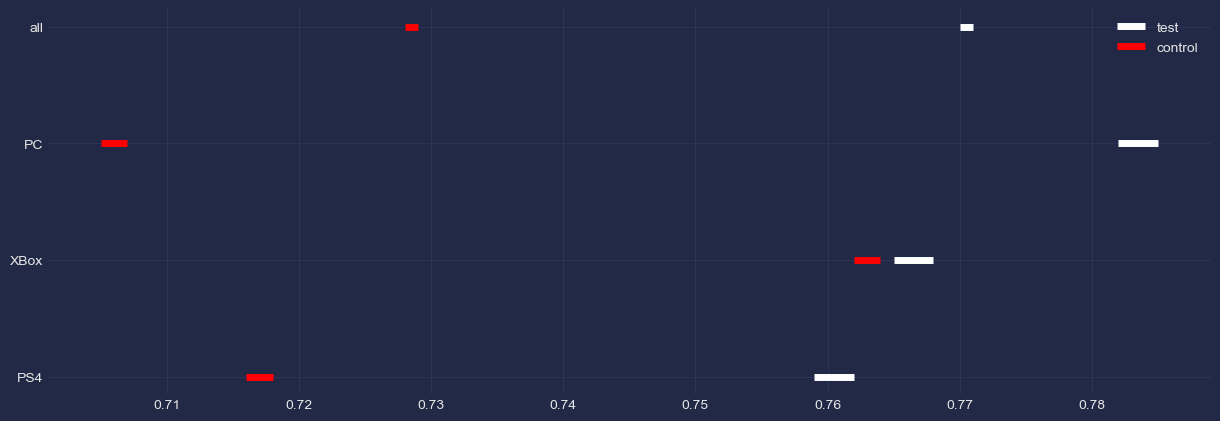

In [271]:
#проверка доверительных интервалов

result_interval_dict = {}
interval_results = pd.DataFrame()

confidence = 0.95

if len(test_group_names) == len(control_group_names):
    for index in range(len(control_group_names)):
        test_sample_name = test_group_names[index]
        control_sample_name = control_group_names[index]
        test_sample_values = samples[test_sample_name]
        control_sample_values = samples[control_sample_name]
        interval_test = st.norm.interval(confidence=confidence, loc=np.mean(test_sample_values), scale=st.sem(test_sample_values))
        interval_control = st.norm.interval(confidence=confidence, loc=np.mean(control_sample_values), scale=st.sem(control_sample_values))
        low_test = round(interval_test[0], 3)
        high_test = round(interval_test[1], 3)
        low_control = round(interval_control[0], 3)
        high_control = round(interval_control[1], 3)
        result_interval_dict['group_1'] = str(test_sample_name)
        result_interval_dict['group_2'] = str(control_sample_name)
        result_interval_dict['low_test'] = low_test
        result_interval_dict['high_test'] = high_test
        result_interval_dict['low_control'] = low_control
        result_interval_dict['high_control'] = high_control
        if (low_test <= high_control) or (low_control <= high_test):
            result_interval_dict['result'] = 'Интервалы не пересекаются'
        else:
            result_interval_dict['result'] = 'Интервалы пересекаются'
        interval_results = interval_results._append(result_interval_dict, ignore_index = True)

fig = plt.figure(figsize = (15, 5))

if len(platforms_list) == 3:
    platforms_list += ['all']
        
plt.hlines(platforms_list,
           interval_results['low_test'],
           interval_results['high_test'],
           color = 'white', linewidth = 5, label='test')
plt.hlines(platforms_list,
           interval_results['low_control'],
           interval_results['high_control'],
           color = 'red', linewidth = 5, label='control')

plt.legend()

In [147]:
#проверка статистической значимости данных для трат внутриигровой валюты

# подготовка списков (выборок)

dimensions_cash = [column for column in cash_group_platform][3:]
name_cash = 'list_cash'
iterable_dict_cash = {}
samples_list_cash = []
samples_cash = {}

for dimension in dimensions_cash:
    values_list = list(cash_group_platform[dimension].unique())
    my_dict = {dimension: values_list}
    iterable_dict_cash.update(my_dict)

groups_list_cash = list(iterable_dict_cash.values())[0]
platforms_list_cash = list(iterable_dict_cash.values())[1]

for group in groups_list_cash:
    samples_list_cash.append([group, platforms_list_cash])

for group in samples_list_cash:
    group_name = group[0]
    for platform in group[1]:
        file_name = str(name_cash + '_' + str(group_name) + '_' + str(platform))
        my_dict = {file_name: list(cash_group_platform[(cash_group_platform['group'] == group_name)\
                                               & (cash_group_platform['platform'] == platform)]['cash'])}
        samples_cash.update(my_dict)

d1_cash = {'list_cash_test_all': list(cash_group_platform[(cash_group_platform['group'] == 'test')]['cash'])}
d2_cash = {'list_cash_control_all': list(cash_group_platform[(cash_group_platform['group'] == 'control')]['cash'])}

samples_cash.update(d1_cash)
samples_cash.update(d2_cash)

#проверка разности дисперсий для t-критерия Стьюдента

test_group_names_cash = []
control_group_names_cash = []

for sample_name in list(samples_cash.keys()):
    if 'test' in sample_name:
        test_group_names_cash.append(sample_name)
    elif 'control' in sample_name:
        control_group_names_cash.append(sample_name)

if len(test_group_names_cash) == len(control_group_names_cash):
    for index in range(len(control_group_names_cash)):
        test_sample_name = test_group_names_cash[index]
        control_sample_name = control_group_names_cash[index]
        test_sample_values = samples_cash[test_sample_name]
        control_sample_values = samples_cash[control_sample_name]
        print('\n' + 'Сравниваем группы:\n' + str(test_sample_name) + '\n' + str(control_sample_name))
        diff = pd.Series(samples_cash[test_sample_name]).std() - pd.Series(samples_cash[control_sample_name]).std()
        print('Разница дисперсий =', round(diff, 5))
        
#проверка статистической значимости данных

#выполнение статистических тестов

result_dict_cash = {}
t_results_cash = pd.DataFrame()

if len(test_group_names_cash) == len(control_group_names_cash):
    for index in range(len(control_group_names_cash)):
        test_sample_name = test_group_names_cash[index]
        control_sample_name = control_group_names_cash[index]
        test_sample_values = samples_cash[test_sample_name]
        control_sample_values = samples_cash[control_sample_name]
        result_dict_cash['group_1'] = str(test_sample_name)
        result_dict_cash['group_2'] = str(control_sample_name)
        result_dict_cash['p-value (t-test)'] = st.ttest_ind(test_sample_values, control_sample_values)[1]
        t_results_cash = t_results_cash._append(result_dict_cash, ignore_index = True)
        
#проверка доверительных интервалов

result_interval_dict_cash = {}
interval_results_cash = pd.DataFrame()

confidence = 0.95

if len(test_group_names_cash) == len(control_group_names_cash):
    for index in range(len(control_group_names_cash)):
        test_sample_name = test_group_names_cash[index]
        control_sample_name = control_group_names_cash[index]
        test_sample_values = samples_cash[test_sample_name]
        control_sample_values = samples_cash[control_sample_name]
        interval_test = st.norm.interval(confidence=confidence, loc=np.mean(test_sample_values), scale=st.sem(test_sample_values))
        interval_control = st.norm.interval(confidence=confidence, loc=np.mean(control_sample_values), scale=st.sem(control_sample_values))
        low_test = round(interval_test[0], 3)
        high_test = round(interval_test[1], 3)
        low_control = round(interval_control[0], 3)
        high_control = round(interval_control[1], 3)
        result_interval_dict_cash['group_1'] = str(test_sample_name)
        result_interval_dict_cash['group_2'] = str(control_sample_name)
        result_interval_dict_cash['low_test'] = low_test
        result_interval_dict_cash['high_test'] = high_test
        result_interval_dict_cash['low_control'] = low_control
        result_interval_dict_cash['high_control'] = high_control
        if (low_test <= high_control) or (low_control <= high_test):
            result_interval_dict_cash['result'] = 'Интервалы не пересекаются'
        else:
            result_interval_dict_cash['result'] = 'Интервалы пересекаются'
        interval_results_cash = interval_results_cash._append(result_interval_dict_cash, ignore_index = True)



Сравниваем группы:
list_cash_test_XBox
list_cash_control_XBox
Разница дисперсий = 6.44698

Сравниваем группы:
list_cash_test_PS4
list_cash_control_PS4
Разница дисперсий = 39.27344

Сравниваем группы:
list_cash_test_PC
list_cash_control_PC
Разница дисперсий = 88.45878

Сравниваем группы:
list_cash_test_all
list_cash_control_all
Разница дисперсий = 43.62609


In [152]:
t_results_cash

,group_1,group_2,p-value (t-test)
0,list_cash_test_XBox,list_cash_control_XBox,5.125752e-13
1,list_cash_test_PS4,list_cash_control_PS4,0.000000e+00
2,list_cash_test_PC,list_cash_control_PC,0.000000e+00
3,list_cash_test_all,list_cash_control_all,0.000000e+00


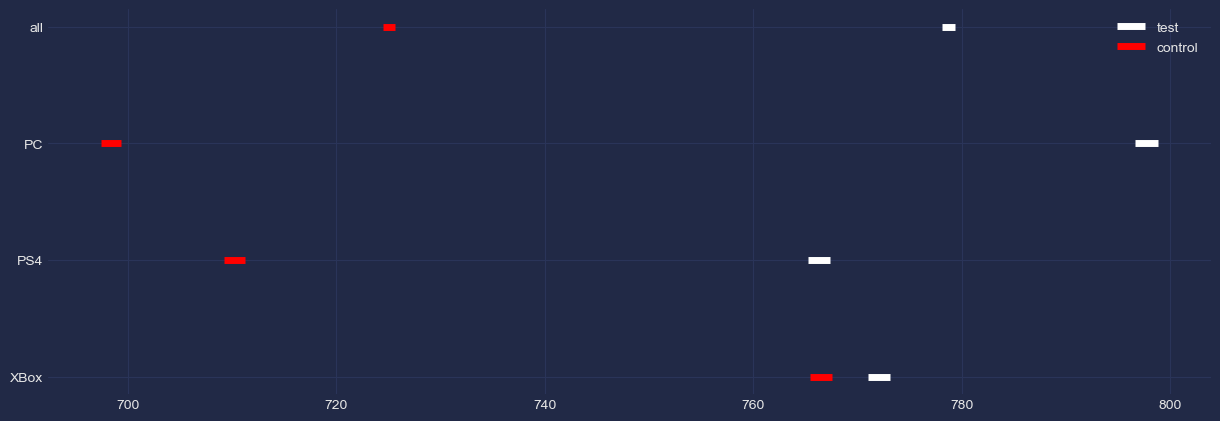

In [272]:
if len(platforms_list_cash) == 3:
    platforms_list_cash += ['all']

fig = plt.figure(figsize = (15, 5))

plt.hlines(platforms_list_cash,
           interval_results_cash['low_test'],
           interval_results_cash['high_test'],
           color = 'white', linewidth = 5, label='test')
plt.hlines(platforms_list_cash,
           interval_results_cash['low_control'],
           interval_results_cash['high_control'],
           color = 'red', linewidth = 5, label='control')

plt.legend()

In [155]:
#расчёт ARPU и ARPPU по донатам

#функция для расчёта метрик
def count_metric(x, metric, data):
    result = {
        'test_sum': x['test'].sum(),
        'control_sum': x['control'].sum()
    }
    output = {'user_count': sum(result.values())}
    output[data] = x[data].sum()
    output[metric] = output[data] / output['user_count']
    return pd.Series(output)


#ARPU
ARPU = pd.DataFrame(money_group_platform)
ARPU['test'] = np.where(ARPU['group'] == 'test', 1, 0)
ARPU['control'] = np.where(ARPU['group'] == 'control', 1, 0)
ARPU = ARPU.groupby(by=['group', 'date', 'platform']).apply(lambda x: count_metric(x, 'ARPU', 'money')).reset_index()
ARPU = ARPU.sort_values(by='date')

#ARPPU - сначала отбор только заплативших игроков, затем расчёт
money_per_user = money_group_platform.groupby(by=['user_id', 'date', 'group', 'platform']).money.sum().reset_index()
ARPPU = money_per_user.drop(money_per_user.loc[money_per_user['money'] == 0].index)
ARPPU['test'] = np.where(ARPPU['group'] == 'test', 1, 0)
ARPPU['control'] = np.where(ARPPU['group'] == 'control', 1, 0)
ARPPU = ARPPU.groupby(by=['group', 'date', 'platform']).apply(lambda x: count_metric(x, 'ARPPU', 'money')).reset_index()
ARPPU = ARPPU.sort_values(by='date')



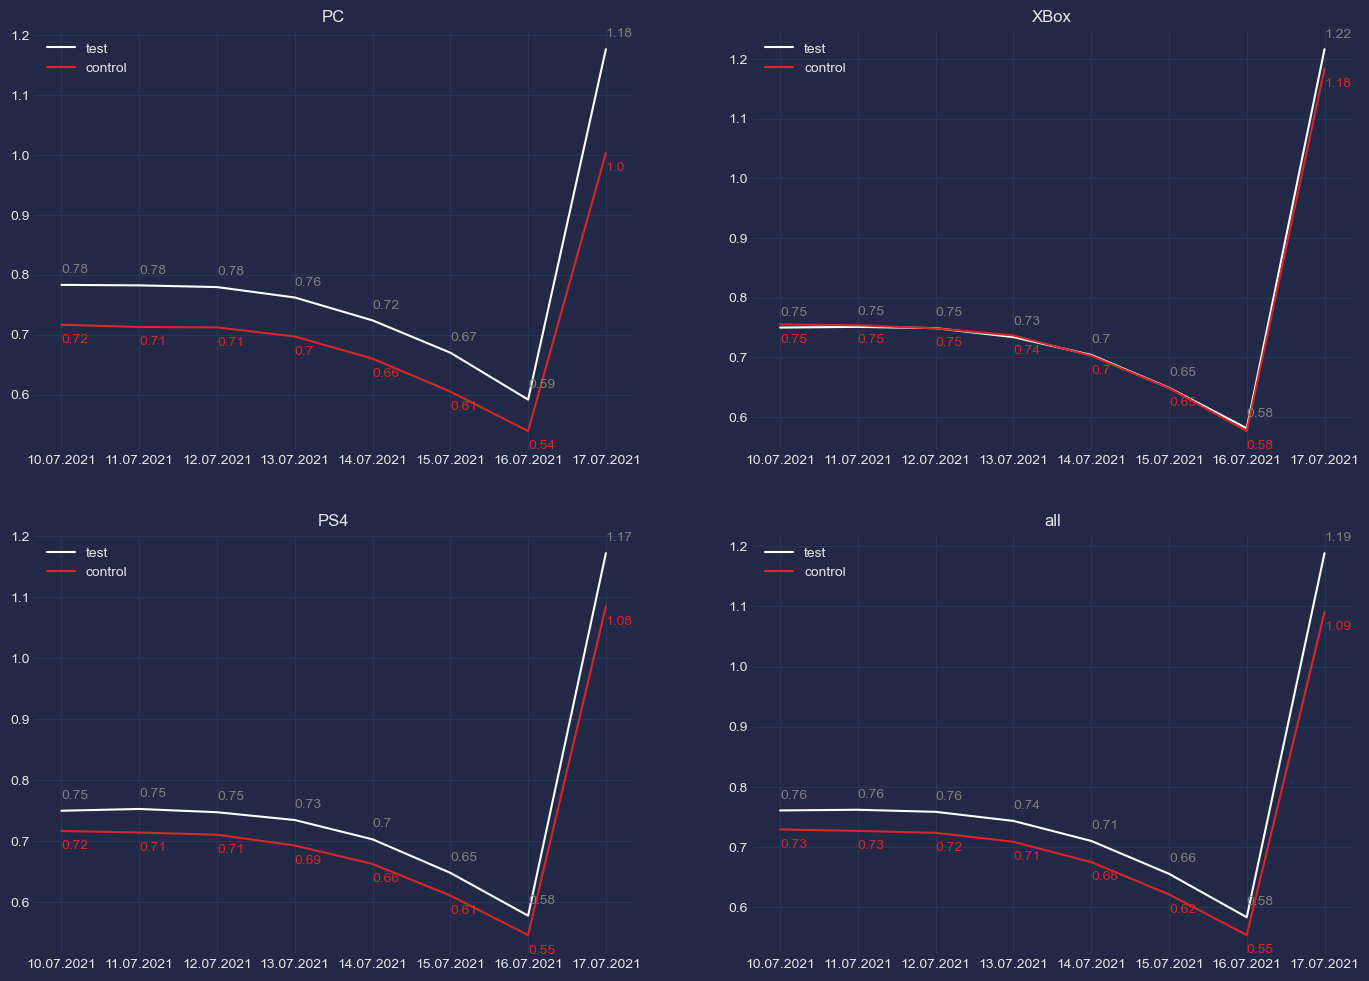

In [286]:
# ARPU временные ряды

f, axarr = plt.subplots(2, 2, figsize=(17, 12))

ARPU_all = ARPU.groupby(by = ['group', 'date']).ARPU.mean().reset_index()

ARPU_test_PC = ARPU[(ARPU['group'] == 'test') & (ARPU['platform'] == 'PC')]
ARPU_control_PC = ARPU[(ARPU['group'] == 'control') & (ARPU['platform'] == 'PC')]
ARPU_test_XBox = ARPU[(ARPU['group'] == 'test') & (ARPU['platform'] == 'XBox')]
ARPU_control_XBox = ARPU[(ARPU['group'] == 'control') & (ARPU['platform'] == 'XBox')]
ARPU_test_PS4 = ARPU[(ARPU['group'] == 'test') & (ARPU['platform'] == 'PS4')]
ARPU_control_PS4 = ARPU[(ARPU['group'] == 'control') & (ARPU['platform'] == 'PS4')]
ARPU_test_all = ARPU_all[(ARPU_all['group'] == 'test')]
ARPU_control_all = ARPU_all[(ARPU_all['group'] == 'control')]


# PC
axarr[0, 0].plot('date', 'ARPU', data=ARPU_test_PC, color='white', label='test')
axarr[0, 0].plot('date', 'ARPU', data=ARPU_control_PC, color='tab:red', label='control')

for string in ARPU_test_PC.itertuples():
    axarr[0, 0].annotate(round(string[6], 2), xy=(string[2], string[6] + 0.02), color='tab:grey')

for string in ARPU_control_PC.itertuples():
    axarr[0, 0].annotate(round(string[6], 2), xy=(string[2], string[6] - 0.03), color='tab:red')
    
axarr[0, 0].title.set_text('PC')
axarr[0, 0].legend()


# XBox
axarr[0, 1].plot('date', 'ARPU', data=ARPU_test_XBox, color='white', label='test')
axarr[0, 1].plot('date', 'ARPU', data=ARPU_control_XBox, color='tab:red', label='control')

for string in ARPU_test_XBox.itertuples():
    axarr[0, 1].annotate(round(string[6], 2), xy=(string[2], string[6] + 0.02), color='tab:grey')

for string in ARPU_control_XBox.itertuples():
    axarr[0, 1].annotate(round(string[6], 2), xy=(string[2], string[6] - 0.03), color='tab:red')

axarr[0, 1].title.set_text('XBox')
axarr[0, 1].legend()
    
# PS4   
axarr[1, 0].plot('date', 'ARPU', data=ARPU_test_PS4, color='white', label='test')
axarr[1, 0].plot('date', 'ARPU', data=ARPU_control_PS4, color='tab:red', label='control')

for string in ARPU_test_PS4.itertuples():
    axarr[1, 0].annotate(round(string[6], 2), xy=(string[2], string[6] + 0.02), color='tab:grey')

for string in ARPU_control_PS4.itertuples():
    axarr[1, 0].annotate(round(string[6], 2), xy=(string[2], string[6] - 0.03), color='tab:red')

axarr[1, 0].title.set_text('PS4')
axarr[1, 0].legend()   

# all   
axarr[1, 1].plot('date', 'ARPU', data=ARPU_test_all, color='white', label='test')
axarr[1, 1].plot('date', 'ARPU', data=ARPU_control_all, color='tab:red', label='control')

for string in ARPU_test_all.itertuples():
    axarr[1, 1].annotate(round(string[3], 2), xy=(string[2], string[3] + 0.02), color='tab:grey')

for string in ARPU_control_all.itertuples():
    axarr[1, 1].annotate(round(string[3], 2), xy=(string[2], string[3] - 0.03), color='tab:red')

axarr[1, 1].title.set_text('all')
axarr[1, 1].legend()


#plt.savefig('ARPU.png')
plt.show()

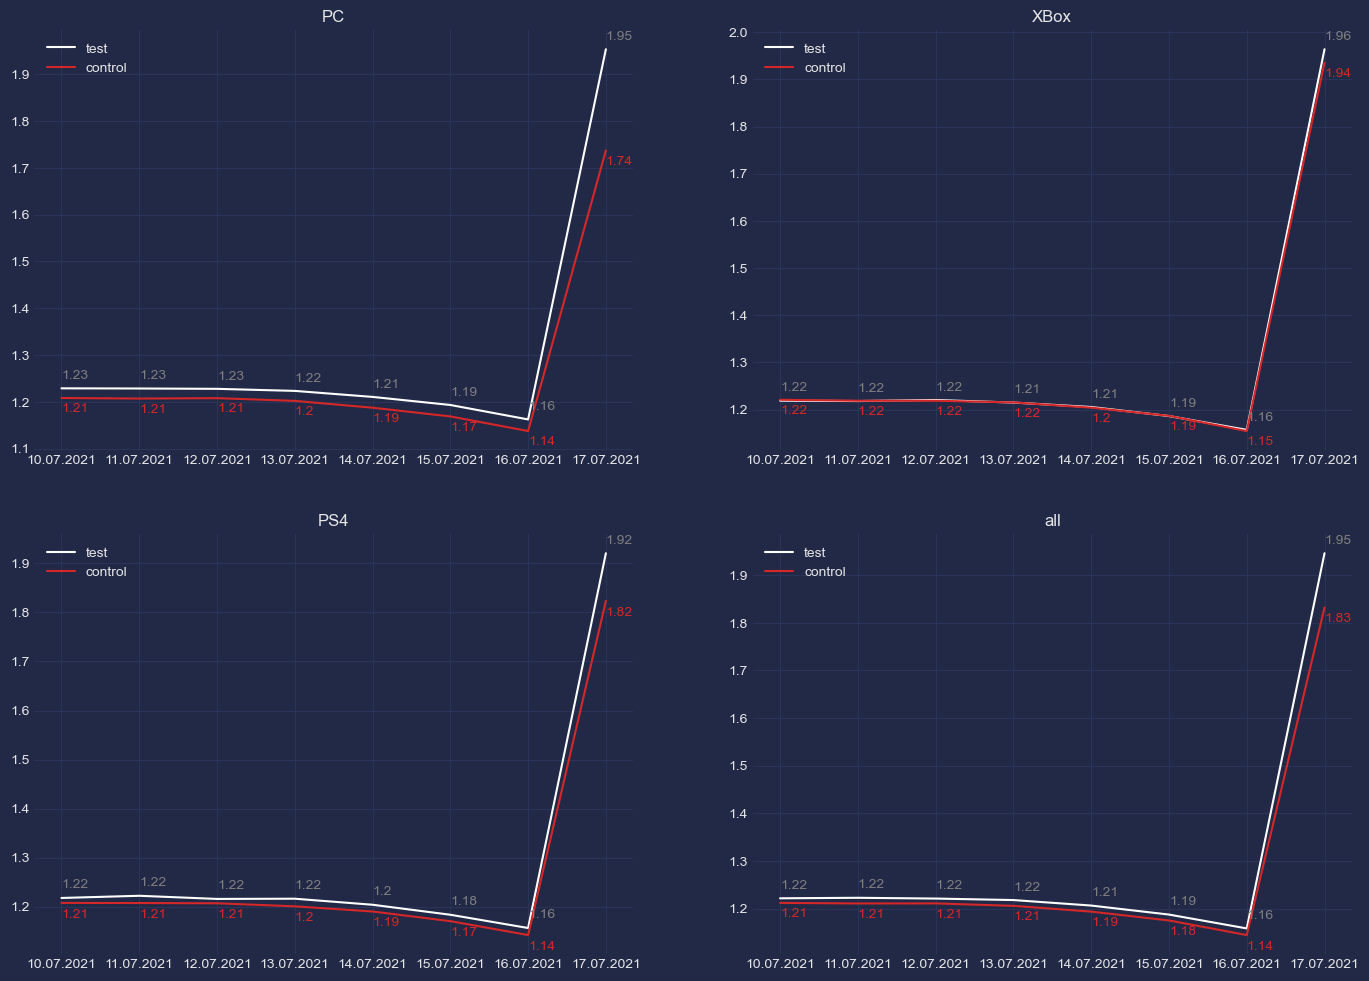

In [283]:
# ARPPU временные ряды

f, axarr = plt.subplots(2, 2, figsize=(17, 12))

ARPPU_all = ARPPU.groupby(by = ['group', 'date']).ARPPU.mean().reset_index()

ARPPU_test_PC = ARPPU[(ARPPU['group'] == 'test') & (ARPPU['platform'] == 'PC')]
ARPPU_control_PC = ARPPU[(ARPPU['group'] == 'control') & (ARPPU['platform'] == 'PC')]
ARPPU_test_XBox = ARPPU[(ARPPU['group'] == 'test') & (ARPPU['platform'] == 'XBox')]
ARPPU_control_XBox = ARPPU[(ARPPU['group'] == 'control') & (ARPPU['platform'] == 'XBox')]
ARPPU_test_PS4 = ARPPU[(ARPPU['group'] == 'test') & (ARPPU['platform'] == 'PS4')]
ARPPU_control_PS4 = ARPPU[(ARPPU['group'] == 'control') & (ARPPU['platform'] == 'PS4')]
ARPPU_test_all = ARPPU_all[(ARPPU_all['group'] == 'test')]
ARPPU_control_all = ARPPU_all[(ARPPU_all['group'] == 'control')]


# PC
axarr[0, 0].plot('date', 'ARPPU', data=ARPPU_test_PC, color='white', label='test')
axarr[0, 0].plot('date', 'ARPPU', data=ARPPU_control_PC, color='tab:red', label='control')

for string in ARPPU_test_PC.itertuples():
    axarr[0, 0].annotate(round(string[6], 2), xy=(string[2], string[6] + 0.02), color='tab:grey')

for string in ARPPU_control_PC.itertuples():
    axarr[0, 0].annotate(round(string[6], 2), xy=(string[2], string[6] - 0.03), color='tab:red')
    
axarr[0, 0].title.set_text('PC')
axarr[0, 0].legend()


# XBox
axarr[0, 1].plot('date', 'ARPPU', data=ARPPU_test_XBox, color='white', label='test')
axarr[0, 1].plot('date', 'ARPPU', data=ARPPU_control_XBox, color='tab:red', label='control')

for string in ARPPU_test_XBox.itertuples():
    axarr[0, 1].annotate(round(string[6], 2), xy=(string[2], string[6] + 0.02), color='tab:grey')

for string in ARPPU_control_XBox.itertuples():
    axarr[0, 1].annotate(round(string[6], 2), xy=(string[2], string[6] - 0.03), color='tab:red')

axarr[0, 1].title.set_text('XBox')
axarr[0, 1].legend()
    
# PS4   
axarr[1, 0].plot('date', 'ARPPU', data=ARPPU_test_PS4, color='white', label='test')
axarr[1, 0].plot('date', 'ARPPU', data=ARPPU_control_PS4, color='tab:red', label='control')

for string in ARPPU_test_PS4.itertuples():
    axarr[1, 0].annotate(round(string[6], 2), xy=(string[2], string[6] + 0.02), color='tab:grey')

for string in ARPPU_control_PS4.itertuples():
    axarr[1, 0].annotate(round(string[6], 2), xy=(string[2], string[6] - 0.03), color='tab:red')

axarr[1, 0].title.set_text('PS4')
axarr[1, 0].legend()   

# all   
axarr[1, 1].plot('date', 'ARPPU', data=ARPPU_test_all, color='white', label='test')
axarr[1, 1].plot('date', 'ARPPU', data=ARPPU_control_all, color='tab:red', label='control')

for string in ARPPU_test_all.itertuples():
    axarr[1, 1].annotate(round(string[3], 2), xy=(string[2], string[3] + 0.02), color='tab:grey')

for string in ARPPU_control_all.itertuples():
    axarr[1, 1].annotate(round(string[3], 2), xy=(string[2], string[3] - 0.03), color='tab:red')

axarr[1, 1].title.set_text('all')
axarr[1, 1].legend()


#plt.savefig('ARPPU.png')
plt.show()


In [329]:
# рост метрик в среднем

metrics_dict = {}
metrics_result = pd.DataFrame()

ARPU_mean = ARPU.groupby(by='group').ARPU.mean()
ARPPU_mean = ARPPU.groupby(by='group').ARPPU.mean()

ARPU_mean_platform = ARPU.groupby(by=['group', 'platform']).ARPU.mean().reset_index()
ARPPU_mean_platform = ARPPU.groupby(by=['group', 'platform']).ARPPU.mean().reset_index()

#в целом
ARPU_dif_all = round(round(ARPU_mean['test'], 3) - round(ARPU_mean['control'], 3), 3)

metrics_dict['metric'] = 'ARPU'
metrics_dict['platform'] = 'all'
metrics_dict['increase'] = ARPU_dif_all
metrics_result = metrics_result._append(metrics_dict, ignore_index = True)


ARPPU_dif_all = round(round(ARPPU_mean['test'], 3) - round(ARPPU_mean['control'], 3), 3)

metrics_dict['metric'] = 'ARPPU'
metrics_dict['platform'] = 'all'
metrics_dict['increase'] = ARPPU_dif_all
metrics_result = metrics_result._append(metrics_dict, ignore_index = True)


#по платформам
for data in [ARPU_mean_platform, ARPPU_mean_platform]:
    for platform in ['PC', 'PS4', 'XBox']:
        metrics = {}
        for group in ['control', 'test']:
            metric = str([column for column in data][2])
            metric_name = f'{metric}_{group}_{platform}'
            metric_value = list(data[(data['group'] == group) & (data['platform'] == platform)][metric])[0]
            metrics.update({metric_name: metric_value})
        diff = round(list(metrics.values())[1] - list(metrics.values())[0], 3)
        test_name = list(metrics.keys())[1]
        control_name = list(metrics.keys())[0]
        
        metrics_dict['metric'] = metric
        metrics_dict['platform'] = platform
        metrics_dict['increase'] = diff
        metrics_result = metrics_result._append(metrics_dict, ignore_index = True)

metrics_result = pd.DataFrame(metrics_result.groupby(by = ['metric', 'platform']).increase.sum())